Connect pymongo and create DB/collection

In [2]:
# start pymongo and create db/collection
import pymongo
client = pymongo.MongoClient("mongodb://localhost:27017/")
dbDev = client["Dev"]
col = dbDev["stock_data"]

Get time series stock data, put in dict

In [4]:
from bson.objectid import ObjectId
from config import api_keys
import json
import ssl
import urllib.request

# select highest protocol supported by client / server
context = ssl.SSLContext(ssl.PROTOCOL_TLS)

ticker = "GOOG"
stock_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol=' + ticker + '&apikey=' + api_keys["stocks"]
#stock_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=' + ticker + '&apikey=' + api_keys["stocks"]

with urllib.request.urlopen(stock_url, context=context) as url:  # decode JSON data
    #data = url.read().decode()  # load to string
    data = json.loads(url.read().decode())  # load straight to dict

type(data)
data

{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes',
  '2. Symbol': 'GOOG',
  '3. Last Refreshed': '2019-04-24',
  '4. Time Zone': 'US/Eastern'},
 'Monthly Time Series': {'2019-04-24': {'1. open': '1184.1000',
   '2. high': '1269.0000',
   '3. low': '1182.0000',
   '4. close': '1256.0000',
   '5. volume': '16801155'},
  '2019-03-29': {'1. open': '1124.9000',
   '2. high': '1231.7900',
   '3. low': '1123.3000',
   '4. close': '1173.3100',
   '5. volume': '31658936'},
  '2019-02-28': {'1. open': '1112.4000',
   '2. high': '1147.0000',
   '3. low': '1086.0000',
   '4. close': '1119.9200',
   '5. volume': '28934646'},
  '2019-01-31': {'1. open': '1016.5700',
   '2. high': '1117.3300',
   '3. low': '1014.0700',
   '4. close': '1116.3700',
   '5. volume': '30714651'},
  '2018-12-31': {'1. open': '1123.1400',
   '2. high': '1124.6500',
   '3. low': '970.1100',
   '4. close': '1035.6100',
   '5. volume': '40256461'},
  '2018-11-30': {'1. open': '1075.8000',
 

In [24]:
# look at format of data
data


{'Meta Data': {'1. Information': 'Monthly Prices (open, high, low, close) and Volumes',
  '2. Symbol': 'GOOG',
  '3. Last Refreshed': '2019-04-24 12:31:16',
  '4. Time Zone': 'US/Eastern'},
 'Monthly Time Series': {'2019-04-24': {'1. open': '1184.1000',
   '2. high': '1269.0000',
   '3. low': '1182.0000',
   '4. close': '1261.7926',
   '5. volume': '16107450'},
  '2019-03-29': {'1. open': '1124.9000',
   '2. high': '1231.7900',
   '3. low': '1123.3000',
   '4. close': '1173.3100',
   '5. volume': '31658936'},
  '2019-02-28': {'1. open': '1112.4000',
   '2. high': '1147.0000',
   '3. low': '1086.0000',
   '4. close': '1119.9200',
   '5. volume': '28934646'},
  '2019-01-31': {'1. open': '1016.5700',
   '2. high': '1117.3300',
   '3. low': '1014.0700',
   '4. close': '1116.3700',
   '5. volume': '30714651'},
  '2018-12-31': {'1. open': '1123.1400',
   '2. high': '1124.6500',
   '3. low': '970.1100',
   '4. close': '1035.6100',
   '5. volume': '40256461'},
  '2018-11-30': {'1. open': '1075

Will need to restructure/cleanse data (can't have periods in mongodb)

In [6]:
# get symbol
symbol = data["Meta Data"]["2. Symbol"]
symbol

'GOOG'

In [7]:
# examine time series format
timeseries = data["Monthly Time Series"]
timeseries

{'2019-04-24': {'1. open': '1184.1000',
  '2. high': '1269.0000',
  '3. low': '1182.0000',
  '4. close': '1256.0000',
  '5. volume': '16801155'},
 '2019-03-29': {'1. open': '1124.9000',
  '2. high': '1231.7900',
  '3. low': '1123.3000',
  '4. close': '1173.3100',
  '5. volume': '31658936'},
 '2019-02-28': {'1. open': '1112.4000',
  '2. high': '1147.0000',
  '3. low': '1086.0000',
  '4. close': '1119.9200',
  '5. volume': '28934646'},
 '2019-01-31': {'1. open': '1016.5700',
  '2. high': '1117.3300',
  '3. low': '1014.0700',
  '4. close': '1116.3700',
  '5. volume': '30714651'},
 '2018-12-31': {'1. open': '1123.1400',
  '2. high': '1124.6500',
  '3. low': '970.1100',
  '4. close': '1035.6100',
  '5. volume': '40256461'},
 '2018-11-30': {'1. open': '1075.8000',
  '2. high': '1095.5700',
  '3. low': '996.0200',
  '4. close': '1094.4300',
  '5. volume': '36735570'},
 '2018-10-31': {'1. open': '1199.8900',
  '2. high': '1209.9600',
  '3. low': '995.8300',
  '4. close': '1076.7700',
  '5. vol

In [19]:
import datetime

# clean dataset
ts_clean =[]
for k,v in timeseries.items():  # enumerate dictionary
#    print(k, k[0:4], k[5:7], k[8:10])
    ts_clean.append({'ticker': symbol, 
                     'date': datetime.datetime(int(k[0:4]), int(k[5:7]), int(k[8:10])),
                     'open': float(v['1. open']),
                     'high': float(v['2. high']),
                     'low': float(v['3. low']),
                     'close': float(v['4. close']),
                     'volume': int(v['5. volume'])
                    })
    
ts_clean
    

[{'ticker': 'GOOG',
  'date': datetime.datetime(2019, 4, 24, 0, 0),
  'open': 1184.1,
  'high': 1269.0,
  'low': 1182.0,
  'close': 1256.0,
  'volume': 16801155},
 {'ticker': 'GOOG',
  'date': datetime.datetime(2019, 3, 29, 0, 0),
  'open': 1124.9,
  'high': 1231.79,
  'low': 1123.3,
  'close': 1173.31,
  'volume': 31658936},
 {'ticker': 'GOOG',
  'date': datetime.datetime(2019, 2, 28, 0, 0),
  'open': 1112.4,
  'high': 1147.0,
  'low': 1086.0,
  'close': 1119.92,
  'volume': 28934646},
 {'ticker': 'GOOG',
  'date': datetime.datetime(2019, 1, 31, 0, 0),
  'open': 1016.57,
  'high': 1117.33,
  'low': 1014.07,
  'close': 1116.37,
  'volume': 30714651},
 {'ticker': 'GOOG',
  'date': datetime.datetime(2018, 12, 31, 0, 0),
  'open': 1123.14,
  'high': 1124.65,
  'low': 970.11,
  'close': 1035.61,
  'volume': 40256461},
 {'ticker': 'GOOG',
  'date': datetime.datetime(2018, 11, 30, 0, 0),
  'open': 1075.8,
  'high': 1095.57,
  'low': 996.02,
  'close': 1094.43,
  'volume': 36735570},
 {'ticke

In [20]:
# insert records into MongoDB
x = col.insert_many(ts_clean)
#x.inserted_ids

In [21]:
docs = [doc for doc in col.find().sort('date',-1)]
print(len(docs))
docs

918


[{'_id': ObjectId('5cc1123d6d0963e55c1aa5dd'),
  'ticker': 'GOOG',
  'date': datetime.datetime(2019, 4, 24, 0, 0),
  'open': 1184.1,
  'high': 1269.0,
  'low': 1182.0,
  'close': 1256.0,
  'volume': 16801155},
 {'_id': ObjectId('5cc1123d6d0963e55c1aa5de'),
  'ticker': 'GOOG',
  'date': datetime.datetime(2019, 3, 29, 0, 0),
  'open': 1124.9,
  'high': 1231.79,
  'low': 1123.3,
  'close': 1173.31,
  'volume': 31658936},
 {'_id': ObjectId('5cc1123d6d0963e55c1aa5df'),
  'ticker': 'GOOG',
  'date': datetime.datetime(2019, 2, 28, 0, 0),
  'open': 1112.4,
  'high': 1147.0,
  'low': 1086.0,
  'close': 1119.92,
  'volume': 28934646},
 {'_id': ObjectId('5cc1123d6d0963e55c1aa5e0'),
  'ticker': 'GOOG',
  'date': datetime.datetime(2019, 1, 31, 0, 0),
  'open': 1016.57,
  'high': 1117.33,
  'low': 1014.07,
  'close': 1116.37,
  'volume': 30714651},
 {'_id': ObjectId('5cc1123d6d0963e55c1aa5e1'),
  'ticker': 'GOOG',
  'date': datetime.datetime(2018, 12, 31, 0, 0),
  'open': 1123.14,
  'high': 1124.65,

In [22]:
docs = [doc for doc in col.find().sort('date',-1)]
docs

#col.delete_many({})

[{'_id': ObjectId('5cc1123d6d0963e55c1aa5dd'),
  'ticker': 'GOOG',
  'date': datetime.datetime(2019, 4, 24, 0, 0),
  'open': 1184.1,
  'high': 1269.0,
  'low': 1182.0,
  'close': 1256.0,
  'volume': 16801155},
 {'_id': ObjectId('5cc1123d6d0963e55c1aa5de'),
  'ticker': 'GOOG',
  'date': datetime.datetime(2019, 3, 29, 0, 0),
  'open': 1124.9,
  'high': 1231.79,
  'low': 1123.3,
  'close': 1173.31,
  'volume': 31658936},
 {'_id': ObjectId('5cc1123d6d0963e55c1aa5df'),
  'ticker': 'GOOG',
  'date': datetime.datetime(2019, 2, 28, 0, 0),
  'open': 1112.4,
  'high': 1147.0,
  'low': 1086.0,
  'close': 1119.92,
  'volume': 28934646},
 {'_id': ObjectId('5cc1123d6d0963e55c1aa5e0'),
  'ticker': 'GOOG',
  'date': datetime.datetime(2019, 1, 31, 0, 0),
  'open': 1016.57,
  'high': 1117.33,
  'low': 1014.07,
  'close': 1116.37,
  'volume': 30714651},
 {'_id': ObjectId('5cc1123d6d0963e55c1aa5e1'),
  'ticker': 'GOOG',
  'date': datetime.datetime(2018, 12, 31, 0, 0),
  'open': 1123.14,
  'high': 1124.65,

Consolidating our work, a basic loop/function structure to load multiple stock tickers into our MongoDB

In [23]:
from bson.objectid  import ObjectId  
from config import api_keys
import json
import ssl
import urllib.request


def clean_time_series_monthly(data):
    
    symbol = data["Meta Data"]["2. Symbol"]
    timeseries = data["Monthly Time Series"]

    ts_clean =[]
    for k,v in timeseries.items():  # enumerate dictionary
        ts_clean.append({'ticker': symbol, 
                         'date': datetime.datetime(int(k[0:4]), int(k[5:7]), int(k[8:10])),
                         'open': float(v['1. open']),
                         'high': float(v['2. high']),
                         'low': float(v['3. low']),
                         'close': float(v['4. close']),
                         'volume': int(v['5. volume'])
                        })

    return ts_clean


# select highest protocol supported by client / server
context = ssl.SSLContext(ssl.PROTOCOL_TLS)

col.delete_many({})

tickers = ["GOOG","FB","NFLX","AAPL","SPY","QQQ","DJIA","IWM"]

for ticker in tickers:
    try:
        stock_url = 'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol=' + ticker + '&apikey=' + api_keys["stocks"]
        with urllib.request.urlopen(stock_url, context=context) as url:  # decode JSON data
            data = json.loads(url.read().decode())  # load straight to dict
            ts_clean = clean_time_series_monthly(data)
            col.insert_many(ts_clean)
    except Exception as e:
        print(ticker, e)
    
stocks = [doc for doc in col.find({})]
print(len(stocks))


QQQ 'Meta Data'
DJIA 'Meta Data'
IWM 'Meta Data'
857


In [24]:
[x for x in stocks if x['ticker'] == "FB"]

[{'_id': ObjectId('5cc1125e6d0963e55c1aa657'),
  'ticker': 'FB',
  'date': datetime.datetime(2019, 4, 24, 0, 0),
  'open': 167.83,
  'high': 185.14,
  'low': 167.2789,
  'close': 182.58,
  'volume': 259506846},
 {'_id': ObjectId('5cc1125e6d0963e55c1aa658'),
  'ticker': 'FB',
  'date': datetime.datetime(2019, 3, 29, 0, 0),
  'open': 162.6,
  'high': 174.3,
  'low': 159.28,
  'close': 166.69,
  'volume': 388172717},
 {'_id': ObjectId('5cc1125e6d0963e55c1aa659'),
  'ticker': 'FB',
  'date': datetime.datetime(2019, 2, 28, 0, 0),
  'open': 165.84,
  'high': 172.47,
  'low': 159.59,
  'close': 161.45,
  'volume': 302243555},
 {'_id': ObjectId('5cc1125e6d0963e55c1aa65a'),
  'ticker': 'FB',
  'date': datetime.datetime(2019, 1, 31, 0, 0),
  'open': 128.99,
  'high': 171.68,
  'low': 128.56,
  'close': 166.69,
  'volume': 527561443},
 {'_id': ObjectId('5cc1125e6d0963e55c1aa65b'),
  'ticker': 'FB',
  'date': datetime.datetime(2018, 12, 31, 0, 0),
  'open': 143.0,
  'high': 147.19,
  'low': 123.02

In [25]:
# can go straight into a DataFrame
import pandas
from pandas import DataFrame

df = DataFrame([x for x in stocks if x['ticker'] == "FB"])
df = df[["ticker","date","open","high","low","close","volume"]]
df.head()

,ticker,date,open,high,low,close,volume
0,FB,2019-04-24,167.83,185.14,167.2789,182.58,259506846
1,FB,2019-03-29,162.60,174.30,159.2800,166.69,388172717
2,FB,2019-02-28,165.84,172.47,159.5900,161.45,302243555
3,FB,2019-01-31,128.99,171.68,128.5600,166.69,527561443
4,FB,2018-12-31,143.00,147.19,123.0200,131.09,558786249


Basic line plot for FB

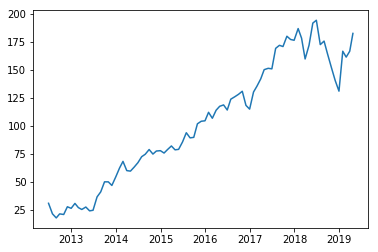

In [28]:
import matplotlib.pyplot as plt

plt.plot(df['date'], df['close'])

In [34]:
#df['hello'] = 1
#df.drop(['hello'], axis=1)